<a href="https://colab.research.google.com/github/balezz/cv_course_fa_mag/blob/main/CodeLab_4_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Семинар 4. Семантическая сегментация Unet

### В этом задании Вам предстоит:
1. Реализовать архитектуру Unet на Keras
2. Обучить свою модель на небольшом датасете и сохранить её  

Источник: https://www.tensorflow.org/tutorials/images/segmentation

### Импорт библиотек и загрузка данных

In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
DATA_DIR = 'pets/'
IMG_LIST = os.listdir(DATA_DIR+'img/')

BATCH_SIZE=10

### Создание датасета из объекта python generator

In [ ]:
# https://docs-python.ru/tutorial/generatory-python/
def data_gen():
    for img_filename in IMG_LIST:
        img = tf.keras.utils.load_img(DATA_DIR+f'img/{img_filename}')
        index = re.findall(r'\d+', img_filename)[0]
        mask = np.load(DATA_DIR+f'mask/{index}.npy') - 1
        yield img, mask

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_generator
dataset = tf.data.Dataset.from_generator(
    data_gen,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.uint8),
        tf.TensorSpec(shape=(256, 256, 1), dtype=tf.int8)),
).cache().batch(BATCH_SIZE)

### Визуализация изображений и масок

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

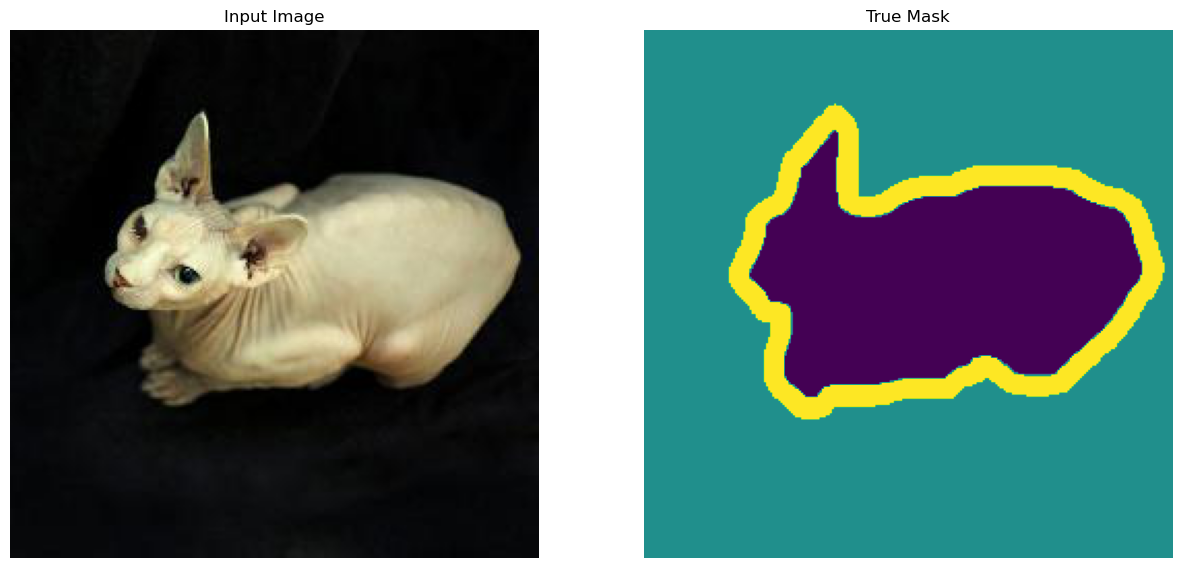

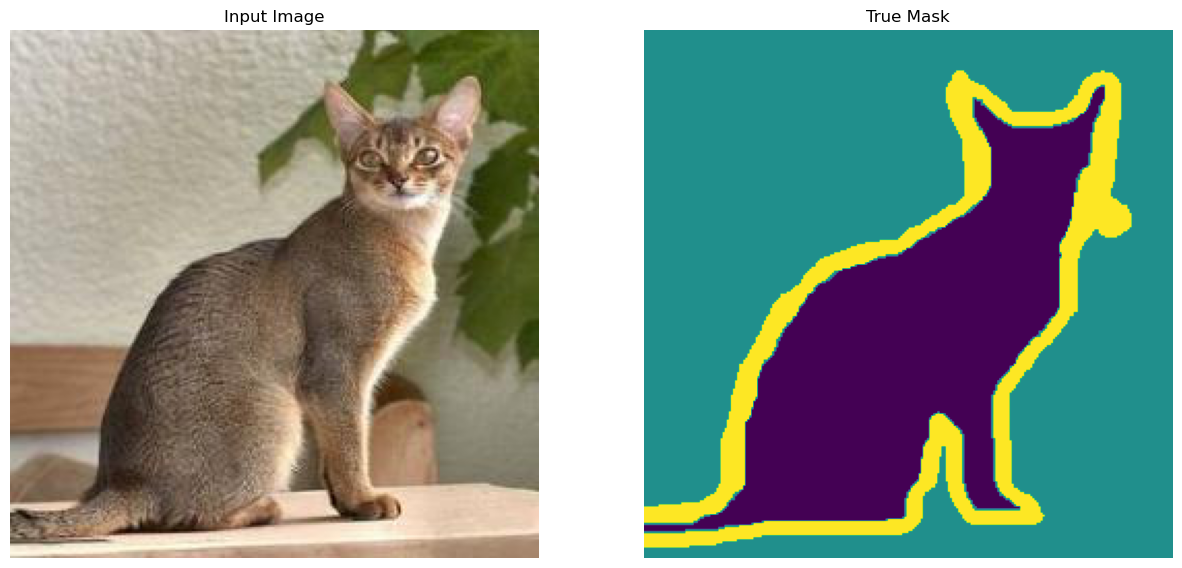

In [ ]:
for images, masks in dataset.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

### Операция Conv2DTranspose (Upconvolution, upsample)
https://arxiv.org/pdf/1603.07285v1.pdf

In [ ]:
x = np.ones((1,5,5,1))
out = layers.Conv2DTranspose(
    filters=1,
    kernel_size=(2,2),
    strides=2,
    kernel_initializer='ones')(x)

In [ ]:
out.numpy().reshape(10,10)

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float32)

### Архитектура Unet 
<img src='https://raw.githubusercontent.com/shreyaspadhy/UNet-Zoo/master/unet.png'>

С помощью Functional API можно строить более гибкие архитектуры.  
Например, несколько слоев можно объединить друг с другом с помощью обычных python - функций. 

In [ ]:
def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 
                      kernel_size=3, 
                      padding = "same", 
                      activation = "relu", 
                      kernel_initializer = "he_normal")(x)
    x = layers.BatchNormalization()(x)
    
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 
                      kernel_size=3,
                      padding = "same",
                      activation = "relu",
                      kernel_initializer = "he_normal")(x)
    x = layers.BatchNormalization()(x)
    
    return x

def downsample_block(x, n_filters):
    conv_features = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(conv_features)
    return conv_features, p

def upsample_block(x, conv_features, n_filters):
    # upsample
        
    x = layers.Conv2DTranspose(n_filters, 
                               kernel_size=2, 
                               strides=2, padding="same")(x)
    
    # concatenate
    x = layers.concatenate([x, conv_features])
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x

### Задание 1. Реализуйте архитектуру Unet на Keras 

Не забудьте про нормализацию входных данных!

In [ ]:
 # inputs
inputs = layers.Input(shape=(256,256,3))

# encoder: contracting path - downsample
# downsample
f1, p1 = downsample_block(inputs, 64)
f2, p2 = downsample_block(p1, 128)
f3, p3 = downsample_block(p2, 256)
f4, p4 = downsample_block(p3, 512)

# bottleneck
bottleneck = double_conv_block(p4, 1024)

# decoder: expanding path - upsample
#  upsample
u1 = upsample_block(bottleneck, f4, 512)
u2 = upsample_block(u1, f3, 256)
u3 = upsample_block(u2, f2, 128)
u4 = upsample_block(u3, f1, 64)

# outputs
outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u4)

# unet model with Keras Functional API
unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

In [ ]:
unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics="accuracy")

### Не забываем проверить модель на малой выборке данных 

In [ ]:
model_history = unet_model.fit(
    dataset.take(4).cache(),
    epochs=5)

Epoch 1/5
4/4 [==============================] - 12s 672ms/step - loss: 1.3978 - accuracy: 0.4119
Epoch 2/5
4/4 [==============================] - 2s 376ms/step - loss: 1.0728 - accuracy: 0.5052
Epoch 3/5
4/4 [==============================] - 2s 373ms/step - loss: 0.9584 - accuracy: 0.6087
Epoch 4/5
4/4 [==============================] - 1s 373ms/step - loss: 0.8990 - accuracy: 0.6272
Epoch 5/5
4/4 [==============================] - 1s 370ms/step - loss: 0.8355 - accuracy: 0.6642


### Вопрос 1. 

Чему равно матожидание начального значения segmentation loss, при условии что для каждого пикселя CE_loss суммируются?  
**Ответ:** 

Сеть не обучена, поэтому для каждого пикселя вероятность принадлежностми каждому из 3 классов равна $q(x) \approx 1/3$. Для одного пикселя функция потерь равна $-\sum_{x=1}^3 p(x) log(1/3) = -log(1/3)$.

Картинка размера 256x256, следовательно, функция потерь для всей картинки равна $-log(1/3)\;256^2 \approx 71998.65$

### Задание 2. Обучите Unet и сохраните модель 

За использование аугментаций для снижения переобучения будут начислены дополнительные баллы.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
class Augment(tf.keras.layers.Layer):  ## Будем менять контраст и отзеркаливать изображения
    def __init__(self):
        super().__init__()
        
        self.contrast = layers.RandomContrast(0.3)
        
    def call(self, inputs, labels):
        
        do_flip = tf.random.uniform([]) > 0.5
        
        inputs = self.contrast(inputs, training=True)
        inputs = tf.cond(do_flip, lambda: tf.image.flip_left_right(inputs), lambda: inputs)
        labels = tf.cond(do_flip, lambda: tf.image.flip_left_right(labels), lambda: labels)
        
        return inputs, labels

In [ ]:
TRAIN_STEPS = int(len(IMG_LIST) * 0.8) // BATCH_SIZE
TEST_STEPS  = int(len(IMG_LIST) * 0.2) // BATCH_SIZE

train_ds = dataset.take(TRAIN_STEPS).cache().repeat().map(Augment()).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = dataset.skip(TRAIN_STEPS).take(TEST_STEPS).cache().repeat()

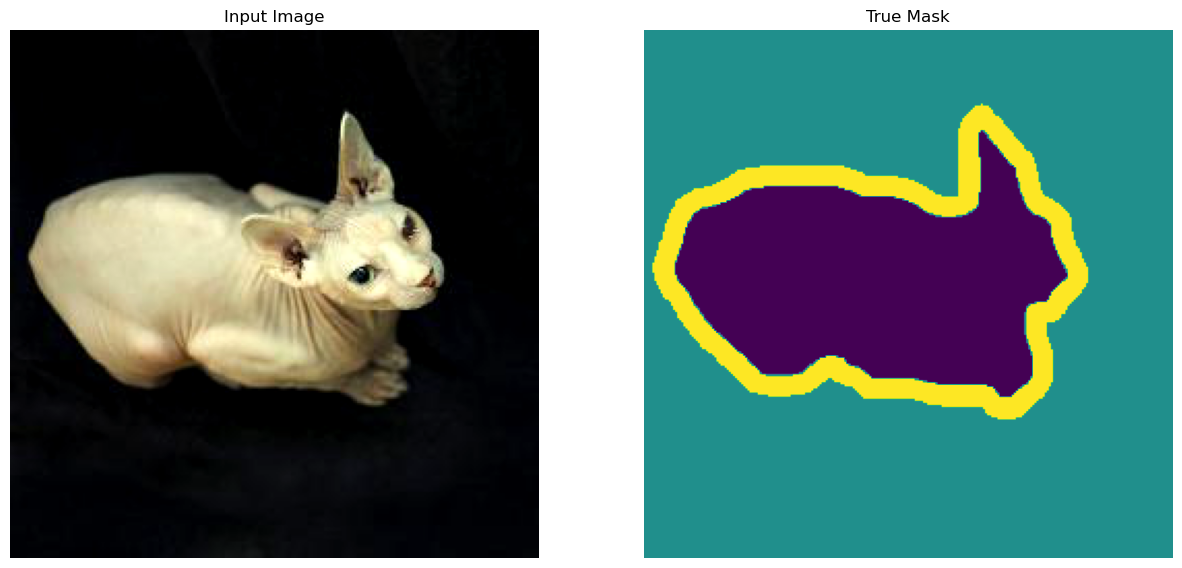

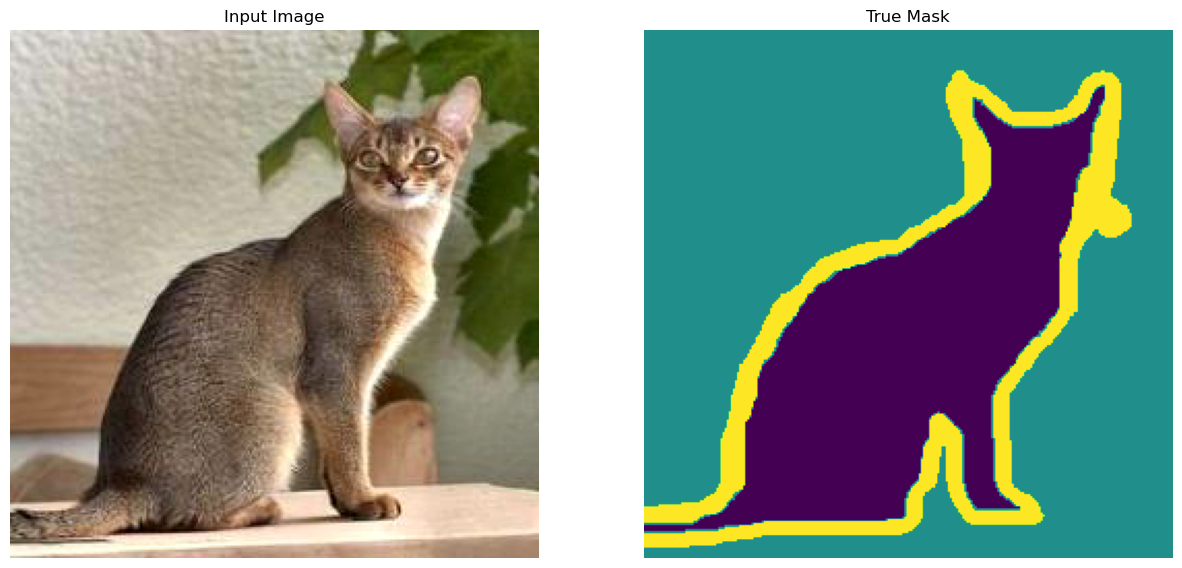

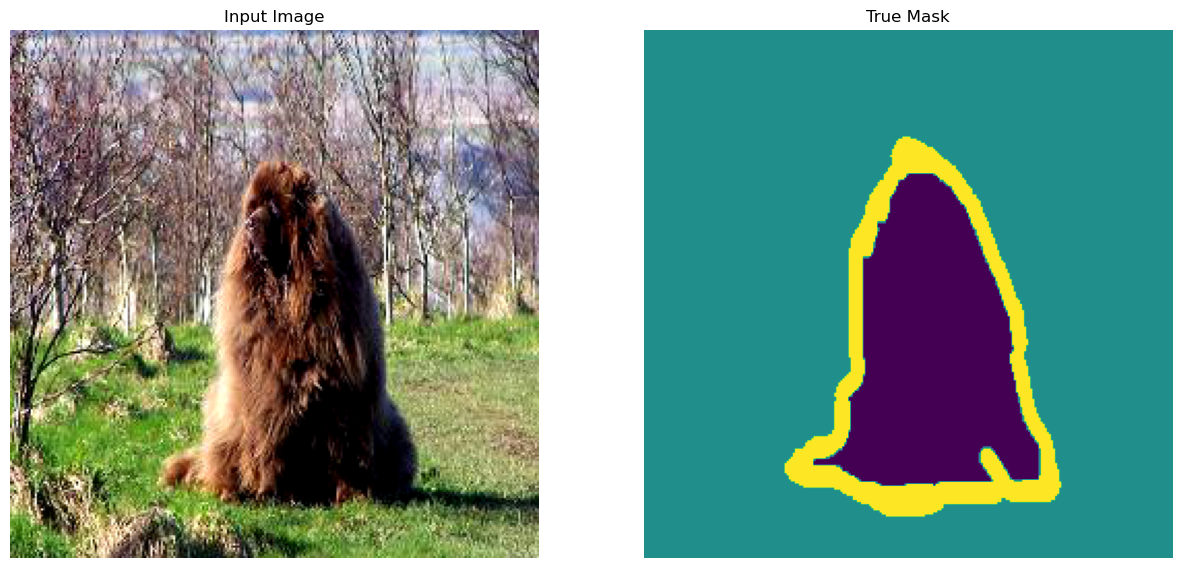

In [ ]:
for images, masks in train_ds.take(3):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

In [ ]:
unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
unet_model.compile(optimizer='Adam',
                loss="sparse_categorical_crossentropy",
                metrics="accuracy")

In [ ]:
checkpoint = ModelCheckpoint('./checkpoints/best', monitor='val_accuracy',
                                                save_best_only=True, save_weights_only=True)  # сохраняем лучшую эпоху

stop_early = EarlyStopping(monitor='val_accuracy', patience=10)

In [ ]:
# todo read the docs
model_history = unet_model.fit(train_ds,
                               epochs=80,
                               validation_data=test_ds,
                               steps_per_epoch=TRAIN_STEPS,
                               validation_steps=TEST_STEPS,
                               callbacks=[checkpoint, stop_early])

Epoch 1/80
294/294 [==============================] - 134s 449ms/step - loss: 0.7067 - accuracy: 0.7068 - val_loss: 3.5977 - val_accuracy: 0.6342
Epoch 2/80
294/294 [==============================] - 115s 391ms/step - loss: 0.5605 - accuracy: 0.7782 - val_loss: 0.9444 - val_accuracy: 0.7266
Epoch 3/80
294/294 [==============================] - 111s 376ms/step - loss: 0.4932 - accuracy: 0.8049 - val_loss: 1.4837 - val_accuracy: 0.6472
Epoch 4/80
294/294 [==============================] - 111s 378ms/step - loss: 0.4384 - accuracy: 0.8285 - val_loss: 1.4558 - val_accuracy: 0.6245
Epoch 5/80
294/294 [==============================] - 112s 382ms/step - loss: 0.4058 - accuracy: 0.8420 - val_loss: 1.1952 - val_accuracy: 0.6568
Epoch 6/80
294/294 [==============================] - 112s 382ms/step - loss: 0.3841 - accuracy: 0.8508 - val_loss: 1.0759 - val_accuracy: 0.6563
Epoch 7/80
294/294 [==============================] - 113s 385ms/step - loss: 0.3639 - accuracy: 0.8591 - val_loss: 0.4535 -

In [ ]:
unet_model.load_weights('./checkpoints/best')
unet_model.save('u-net')

INFO:tensorflow:Assets written to: u-net\assets


INFO:tensorflow:Assets written to: u-net\assets


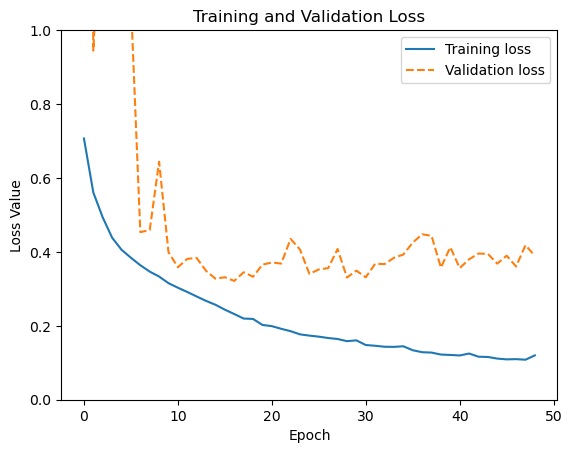

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, '-', label='Training loss')
plt.plot(model_history.epoch, val_loss, '--', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

### Проверим работу модели на выборках train и test

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset, num=1):
    for image, mask in dataset.shuffle(700).take(num):
        pred_mask = unet_model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])

1/1 [==============================] - 0s 19ms/step


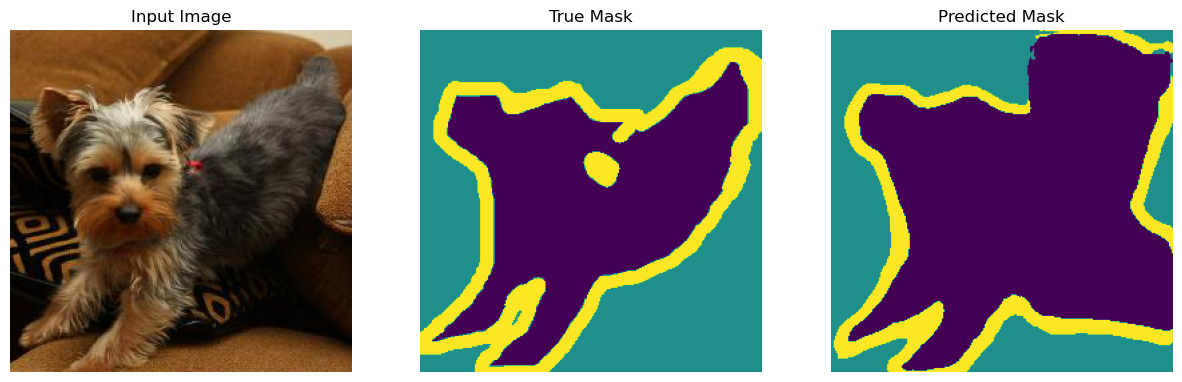

1/1 [==============================] - 0s 20ms/step


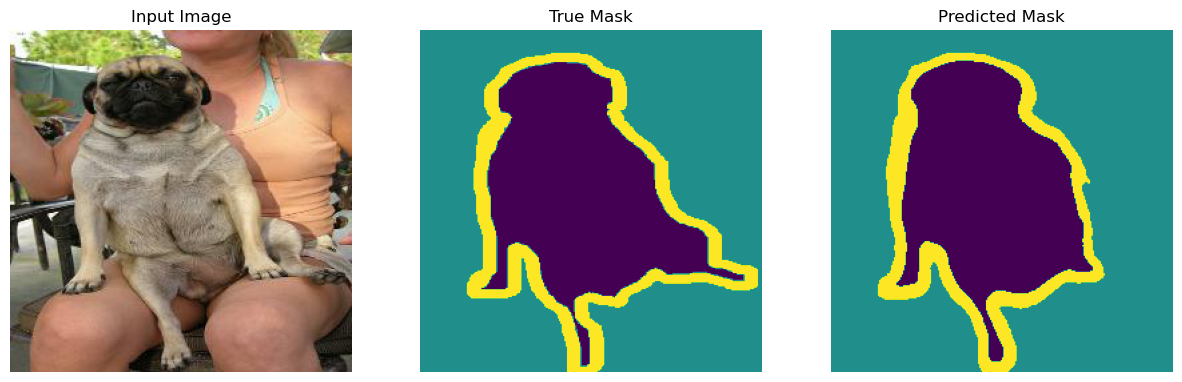

1/1 [==============================] - 0s 22ms/step


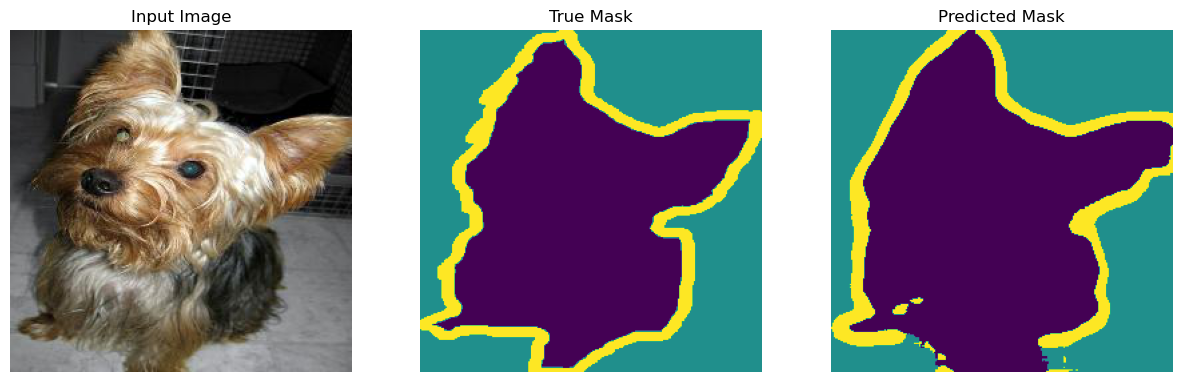

1/1 [==============================] - 0s 20ms/step


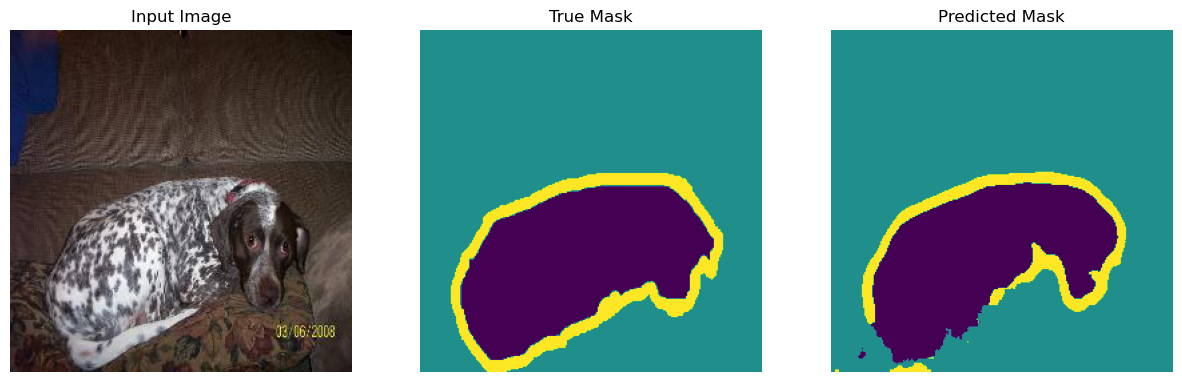

1/1 [==============================] - 0s 20ms/step


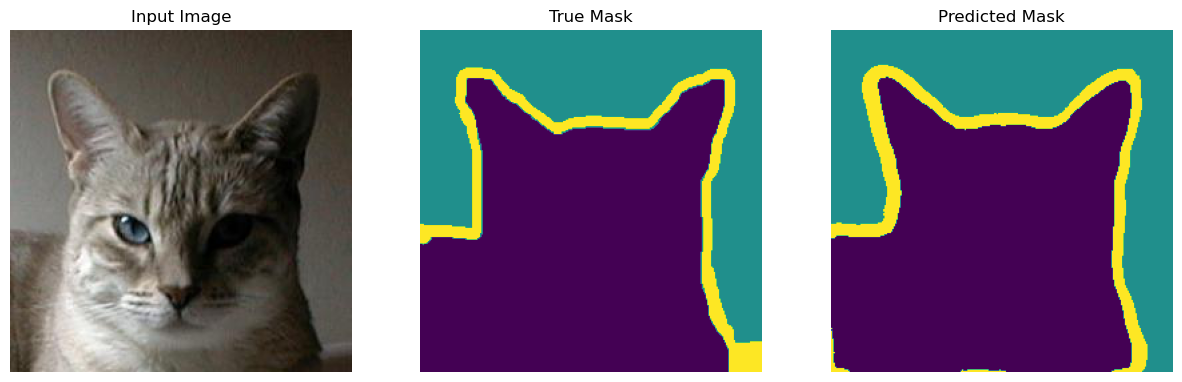

In [ ]:
show_predictions(test_ds, 5)